In [2]:
import mne
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import scipy
import pywt

mne.set_log_level('WARNING')
mne.set_config('MNE_BROWSE_RAW_SIZE','16,8')

# Types
from typing import Annotated, Literal, TypeVar

DType = TypeVar("DType", bound=np.generic)
ArrayN = Annotated[npt.NDArray[DType], Literal['N']]

# Get Data

### Bonn University

Sets A and B are from healthy patients, while Sets C, D, and E are from epileptic patients.

Sets C and D are seizure-free segments while set E is during a seizure.

Each set contains 100 single-channel EEG segments of 23.6-sec duration.

In [3]:
def get_data(sets_to_read: list, channels: int, time_points: int) -> dict[str, np.ndarray]:
    data = dict()

    # maps from set_letter to set_letter_alternate (for the filenames)
    sets_to_file_prefixes = {
        'A': 'Z',
        'B': 'O',
        'C': 'N',
        'D': 'F',
        'E': 'S'
    }

    for set in sets_to_read:
        if set not in sets_to_file_prefixes:
            continue

        set_letter_alternate = sets_to_file_prefixes[set]

        set_data = np.zeros((channels, time_points))
        for i in range(channels):
            filename = f'data/bonn/SET {set}/{set_letter_alternate}{str(i+1).zfill(3)}.txt'
            z = np.loadtxt(filename)
            set_data[i] = z[:time_points]

        data[set] = set_data

    return data

channels, time_points = 100, 4096
freq = 173.61

sets_to_use = ['A', 'E']
data_all_sets = get_data(sets_to_use, channels, time_points)

### Create mne.Raw objects

In [4]:
raws_all_sets = {}
for set in sets_to_use:
    info = mne.create_info(
        ch_names=[f'c{i}' for i in range(channels)],
        sfreq=freq,
        ch_types='eeg',
    )
    raws_all_sets[set] = mne.io.RawArray(data_all_sets[set], info)

# Preprocessing

### Filtering

In [5]:
for set in raws_all_sets:
    # raw.copy().compute_psd().plot()

    # raw.copy().plot(duration=5, n_channels=15, scalings=500)

    raws_all_sets[set] = raws_all_sets[set].notch_filter(freqs=50)
    raws_all_sets[set] = raws_all_sets[set].filter(l_freq=0.1, h_freq=50)

    # raw.copy().compute_psd().plot();
    # raw.copy().plot(duration=5, n_channels=15, scalings=500);
print(raws_all_sets)

{'A': <RawArray | 100 x 4096 (23.6 s), ~3.2 MB, data loaded>, 'E': <RawArray | 100 x 4096 (23.6 s), ~3.2 MB, data loaded>}


/var/folders/jn/90br8jjn68b1psqfzrd83ry40000gn/T/ipykernel_22993/1935024092.py:7: RuntimeWarning: filter_length (5731) is longer than the signal (4096), distortion is likely. Reduce filter length or filter a longer signal.
  raws_all_sets[set] = raws_all_sets[set].filter(l_freq=0.1, h_freq=50)
/var/folders/jn/90br8jjn68b1psqfzrd83ry40000gn/T/ipykernel_22993/1935024092.py:7: RuntimeWarning: filter_length (5731) is longer than the signal (4096), distortion is likely. Reduce filter length or filter a longer signal.
  raws_all_sets[set] = raws_all_sets[set].filter(l_freq=0.1, h_freq=50)


### Segmentation into intervals

In [6]:
total_seconds = time_points/freq
interval_length = 5  # in seconds

segments_all_sets = {}
for set in sets_to_use:
    # create a list of numpy arrays, each containing the data of a single interval
    segments = []
    t = 0
    while t < time_points/freq:
        segments.append(data_all_sets[set][:, int(t*freq):int((t+interval_length)*freq)])
        t += interval_length
    
    segments_all_sets[set] = segments

# Feature Extraction

### Define 1D multilevel DWT function for each time segment (using Daubechies 4)

In [7]:
def discrete_wavelet_transform(data):
    # 1D multilevel DWT
    cA4, cD4, cD3, cD2, cD1 = pywt.wavedec(data, wavelet='db4', level=4)
    # low frequencies => high time resolution, low freq resolution
    # high frequences => low time resolution, high freq resolution
    # print(cA4.shape)  # 0.1-4 Hz   60
    # print(cD4.shape)  # 4-8 Hz     60
    # print(cD3.shape)  # 8-15 Hz    114
    # print(cD2.shape)  # 15-30 Hz   222
    # print(cD1.shape)  # 30-60 Hz   437
    return cA4, cD4, cD3, cD2, cD1

### Define feature vector functions

In [8]:
def variance(data) -> ArrayN[np.float64]:
    variance_data = np.var(data, axis=1)
    return variance_data  # shape (# channels,)

def standard_deviation(data) -> ArrayN[np.float64]:
    std_data = np.std(data, axis=1)
    return std_data

def kurtosis(data) -> ArrayN[np.float64]:
    # fisher = True is default, which subtracts 3 from the final value
    return scipy.stats.kurtosis(data, axis=1, fisher=False)

def nn_shannon_entropy(data) -> ArrayN[np.float64]:
    # shannon entropy - a measure of how uncertain the data is (or how surprising it is?)
    # squared so log is never taken of a negative number in the data
    squared = data**2
    output = np.sum(squared * np.log(squared), axis=1)
    return output
    
    # output2 = np.sum(data * np.log(data), axis=1)
    # return output2   # returns nan because there are negative numbers
    return scipy.stats.entropy(data, axis=1)  # returns -inf

def logarithmic_band_power(data) -> ArrayN[np.float64]:
    n = data.shape[1]
    return np.log(np.sum(data**2, axis=1) / n)

def compute_features(data):
    return np.array([
        logarithmic_band_power(data),
        standard_deviation(data),
        variance(data),
        kurtosis(data),
        nn_shannon_entropy(data)
    ], dtype=np.float64).T

### Define feature vector graphing functions

In [9]:
BandType = Literal['A4', 'D4', 'D3', 'D2', 'D1']
FeatureType = Literal['LBP', 'Std', 'Var', 'Kur', 'SE']

# GETS FEATURE FROM 25 LENGTH FEATURE VECTORS
def get_feature(
        feature_vector: np.ndarray,
        band: BandType,
        feature: FeatureType
    ) -> np.float64:
    
    bands = ['A4', 'D4', 'D3', 'D2', 'D1']
    features = ['LBP', 'Std', 'Var', 'Kur', 'SE']
    
    row = bands.index(band)
    col = features.index(feature)

    return feature_vector[row * len(features) + col]

def graph_feature_vectors(channel_feature_vectors_all_sets: dict[str, np.ndarray], band_x: BandType, band_y: BandType, feature: FeatureType):
    colors = ['blue', 'green', 'yellow', 'red', 'black']

    for i, set in enumerate(channel_feature_vectors_all_sets):
        channel_feature_vectors = channel_feature_vectors_all_sets[set]

        for feature_vector in channel_feature_vectors:
            x = get_feature(feature_vector, band_x, feature)
            y = get_feature(feature_vector, band_y, feature)

            plt.scatter(x, y, color=colors[i])
    
    plt.show()

### Compute feature vector for each segment

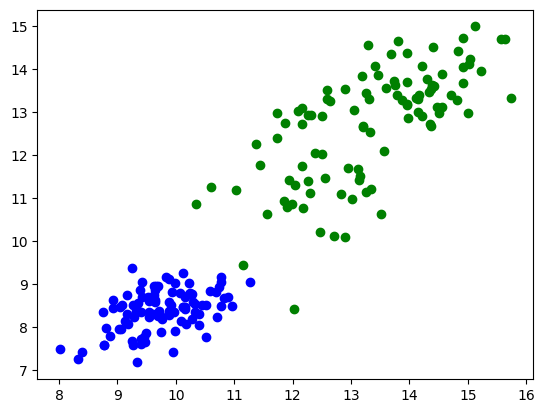

In [10]:
channel_feature_vectors_all_sets = {}

for set in segments_all_sets:
    segments = segments_all_sets[set]

    for i, segment_data in enumerate(segments):
        # interval_data shape = (100, 868)
        if i > 0: break   # TODO debug: to test only 1 interval

        # Perform discrete wavelet transform on data
        dwt_outputs = discrete_wavelet_transform(data=segment_data)

        # 5 features are extracted (LBP, SD, var, kur, SE) from each dwt output, so 5 rows, len(dwt_outputs) cols
        outputs = []
        for i, dwt_output in enumerate(dwt_outputs):
            # dwt_output shape - any of (100, 60), (100, 114), (100, 222), (100, 437)
            # TODO: should the feature vectors be calculated separately for each channel? this would result in 100 * 25 features for each time segment. assuming yes

            # Compute features for each DWT output: [LBP, Std, Var, Kur, SE]
            features = compute_features(dwt_output)   # shape (# channels, 5 features)
            outputs.append(features)

        channel_feature_vectors_all_sets[set] = np.hstack(outputs)  # shape (100, 25)
        # [LBP, Std, Var, Kur, SE] for each DWT-extracted freq band, for each channel

        # graph_feature_vectors(feature_vectors, band_x='A4', band_y='D4', feature='SE')  # seems off

graph_feature_vectors(channel_feature_vectors_all_sets, band_x='A4', band_y='D4', feature='LBP')   # A4 = delta = 0.1-4 Hz, D4 = theta = 4-8 Hz